# Qubit mapping and routing

**Download this notebook - {nb-download}`mapping_example.ipynb`**

In this tutorial we will show how the problem of mapping from logical quantum circuits to physically permitted circuits is solved automatically in TKET. The basic examples require only the installation of pytket, ```pip install pytket```.

There is a wide variety of different blueprints for realising quantum computers, including the well known superconducting and ion trap devices. Different devices come with different constraints, such as a limited primitive gate set for universal quantum computing. Often this limited gate set accommodates an additional constraint, that two-qubit gates can not be executed between all pairs of qubits.

In software, typically this constraint is presented as a "connectivity" graph where vertices connected by an edge represents pairs of physical qubits which two-qubit gates can be executed on. As programmers usually write logical quantum circuits with no sense of architecture (or may want to run their circuit on a range of hardware with different connectivity constraints), most quantum software development kits offer the means to automatically solve this constraint. One common way is to automatically add logical ```SWAP``` gates to a Circuit, changing the position of logical qubits on physical qubits until a two-qubit gate can be realised. This is an active area of research in quantum computing and a problem we discuss in our paper "On The Qubit Routing Problem" - arXiv:1902.08091.

In TKET this constraint is represented by the ```Architecture``` class. An Architecture object requires a coupling map to be created, a list of pairs of qubits which defines where two-qubit primitives may be executed. A coupling map can be produced naively by the integer indexing of nodes and edges in some architecture.

In [1]:
from pytket.architecture import Architecture
from pytket.circuit import Node

In [2]:
import networkx as nx
from typing import List, Union, Tuple

In [3]:
def draw_graph(coupling_map: List[Union[Tuple[int, int], Tuple[Node, Node]]]):
    coupling_graph = nx.Graph(coupling_map)
    nx.draw(coupling_graph, labels={node: node for node in coupling_graph.nodes()})

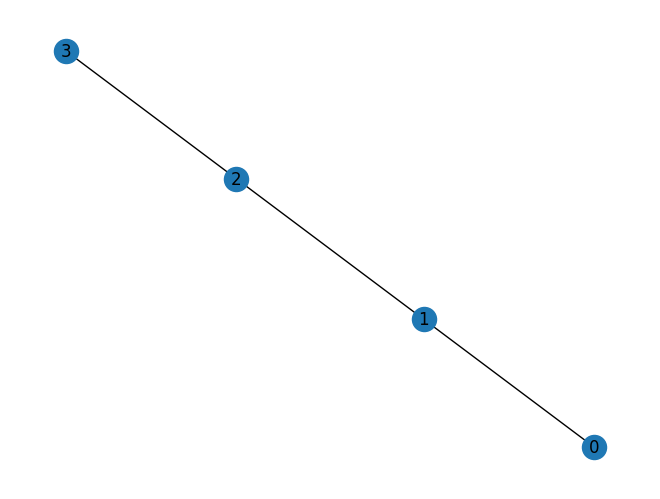

In [4]:
simple_coupling_map = [(0, 1), (1, 2), (2, 3)]
simple_architecture = Architecture(simple_coupling_map)
draw_graph(simple_coupling_map)

Alternatively we could use the `Node` class to assign our nodes - you will see why this can be helpful later. Lets create an Architecture with an identical graph:

In [5]:
node_0 = Node("e0", 0)
node_1 = Node("e1", 1)
node_2 = Node("e2", 2)
node_3 = Node("e3", 3)

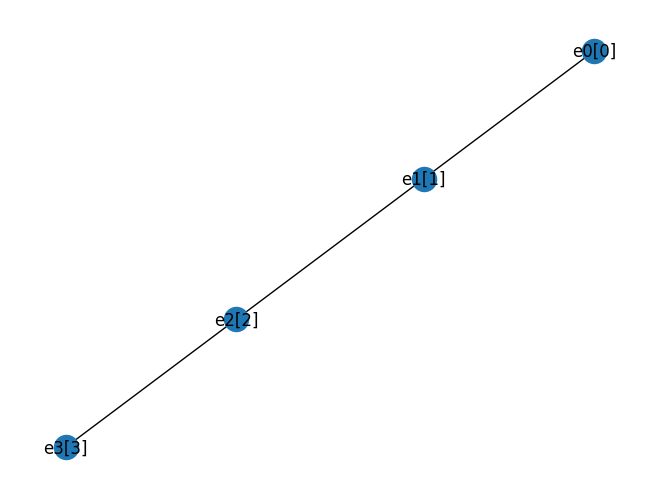

In [6]:
id_coupling_map = [(node_0, node_1), (node_1, node_2), (node_2, node_3)]
id_architecture = Architecture(id_coupling_map)
draw_graph(id_coupling_map)

We can also create an ID with an arbitrary-dimensional index. Let us make a 2x2x2 cube:

In [7]:
node_000 = Node("cube", [0, 0, 0])
node_001 = Node("cube", [0, 0, 1])
node_010 = Node("cube", [0, 1, 0])
node_011 = Node("cube", [0, 1, 1])
node_100 = Node("cube", [1, 0, 0])
node_101 = Node("cube", [1, 0, 1])
node_110 = Node("cube", [1, 1, 0])
node_111 = Node("cube", [1, 1, 1])

In [8]:
cube_coupling_map = [
    (node_000, node_001),
    (node_000, node_010),
    (node_010, node_011),
    (node_001, node_011),
    (node_000, node_100),
    (node_001, node_101),
    (node_010, node_110),
    (node_011, node_111),
    (node_100, node_101),
    (node_100, node_110),
    (node_110, node_111),
    (node_101, node_111),
]

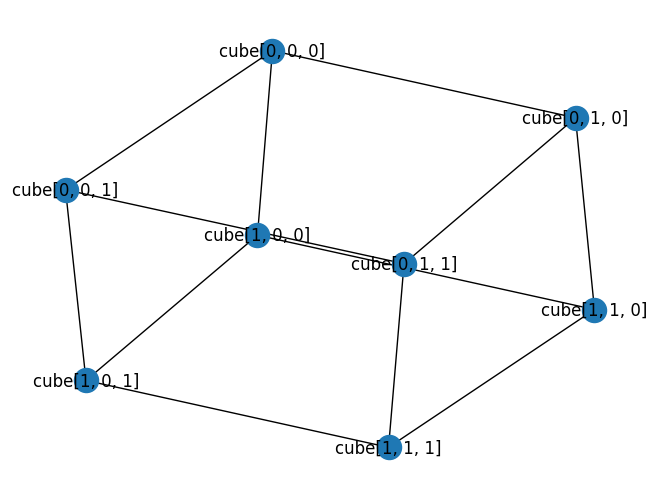

In [9]:
cube_architecture = Architecture(cube_coupling_map)
draw_graph(cube_coupling_map)

To avoid that tedium though we could just use our SquareGrid Architecture:

In [10]:
from pytket.architecture import SquareGrid

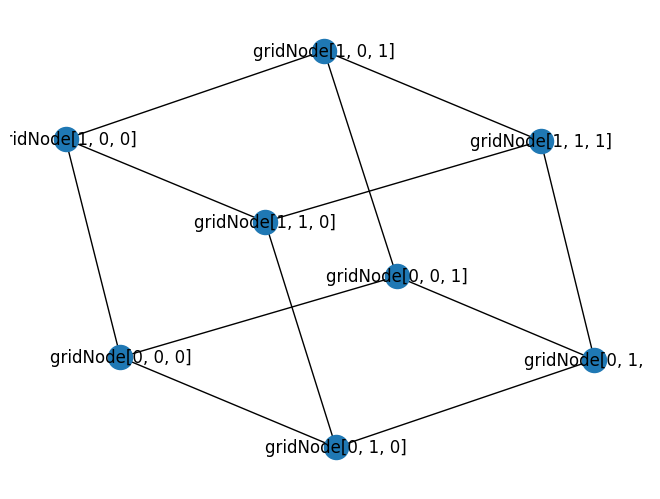

In [11]:
alternative_cube_architecture = SquareGrid(2, 2, 2)
draw_graph(alternative_cube_architecture.coupling)

The current range of quantum computers are commonly referred to as Noisy-Intermediate-Scale-Quantum devices i.e. NISQ devices. The impact of noise is a primary concern during compilation and incentivizes producing physically permitted circuits that have a minimal number of gates. For this reason benchmarking in this area is often completed by comparing the final number of two-qubit (or particularly SWAP gates) in compiled circuits.

However it is important to remember that adding logical SWAP gates to minimise gate count is not the only way this constraint can be met, with large scale architecture-aware synthesis methods and fidelity aware methods amongst other approaches producing viable physically permitted circuits. It is likely that no SINGLE approach is better for all circuits, but the ability to use different approaches where best fitted will give the best results during compilation.

Producing physically valid circuits is completed via the `MappingManager` class, which aims to accomodate a wide range of approaches.

In [12]:
from pytket.mapping import MappingManager

A `MappingManager` object requires an `Architecture` object at construction.

In [13]:
mapping_manager = MappingManager(id_architecture)

All mapping is done through the `MappingManager.route_circuit` method. The `MappingManager.route_circuit` method has two arguments, the first a Circuit to be routed (which is mutated), the second a `List[RoutingMethodCircuit]` object that defines how the mapping is completed.

Later we will look at defining our own `RoutingMethodCircuit` objects, but initially lets consider one thats already available.

In [14]:
from pytket.mapping import LexiLabellingMethod, LexiRouteRoutingMethod

In [15]:
lexi_label = LexiLabellingMethod()
lexi_route = LexiRouteRoutingMethod(10)

The `lexi_route` object here is of little use outside `MappingManager`. Note that it takes a lookahead parameter, which will affect the performance of the method, defining the number of two-qubit gates it considers when finding `SWAP` gates to add.

In [16]:
from pytket import Circuit, OpType
from pytket.circuit import display

In [17]:
c = (
    Circuit(4)
    .CX(0, 1)
    .CX(1, 2)
    .CX(0, 2)
    .CX(0, 3)
    .CX(2, 3)
    .CX(1, 3)
    .CX(0, 1)
    .measure_all()
)
display.render_circuit_jupyter(c)

We can also look at which logical qubits are interacting.

In [18]:
from pytket.utils import Graph

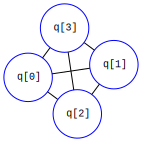

In [19]:
Graph(c).get_qubit_graph()

By running the `MappingManager.route_circuit` method on our circuit `c` with the `LexiLabellingMethod` and `LexiRouteRoutingMethod` objects as an argument, qubits in `c` with some physical requirements will be relabelled and the qubit graph modified (by the addition of SWAP gates and relabelling some CX as BRIDGE gates) such that the qubit graph is isomorphic to some subgraph of the full architecture.

In [20]:
mapping_manager.route_circuit(c, [lexi_label, lexi_route])
display.render_circuit_jupyter(c)

The graph:

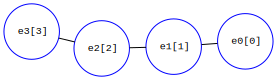

In [21]:
Graph(c).get_qubit_graph()

The resulting circuit may also change if we reduce the lookahead parameter.

In [22]:
c = (
    Circuit(4)
    .CX(0, 1)
    .CX(1, 2)
    .CX(0, 2)
    .CX(0, 3)
    .CX(2, 3)
    .CX(1, 3)
    .CX(0, 1)
    .measure_all()
)
mapping_manager.route_circuit(c, [lexi_label, LexiRouteRoutingMethod(1)])
display.render_circuit_jupyter(c)

We can also pass multiple `RoutingMethod` options for Routing in a ranked List. Each `RoutingMethod` option has a function for checking whether it can usefully modify a subcircuit at a stage in Routing. To choose, each method in the List is checked in order until one returns True. This will be discussed more later.

We can aid the mapping procedure by relabelling qubits in advance. This can be completed using the `Placement` class.

In [23]:
from pytket.placement import Placement, LinePlacement, GraphPlacement

The default ```Placement``` assigns logical qubits to physical qubits as they are encountered during routing. ```LinePlacement``` uses a strategy described in https://arxiv.org/abs/1902.08091. ```GraphPlacement``` is described in Section 7.1 of https://arxiv.org/abs/2003.10611. Lets look at how we can use the ```LinePlacement``` class.`

In [24]:
line_placement = LinePlacement(id_architecture)

In [25]:
c = (
    Circuit(4)
    .CX(0, 1)
    .CX(1, 2)
    .CX(0, 2)
    .CX(0, 3)
    .CX(2, 3)
    .CX(1, 3)
    .CX(0, 1)
    .measure_all()
)
line_placement.place(c)

True

In [26]:
display.render_circuit_jupyter(c)

Note that one qubit remains unplaced in this example. `LexiRouteRoutingMethod` will dynamically assign it during mapping.

Different placements will lead to different selections of SWAP gates being added. However each different routed circuit will preserve the original unitary action of the full circuit while respecting connectivity constraints.

In [27]:
mapping_manager.route_circuit(c, [lexi_label, lexi_route])
display.render_circuit_jupyter(c)

The graph:

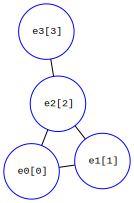

In [28]:
Graph(c).get_qubit_graph()

However, small changes to the depth of lookahead or the original assignment of `Architecture` `Node` can greatly affect the resulting physical circuit for the `LexiRouteRoutingMethod` method. Considering this variance, it should be possible to easily throw additional computational resources at the problem if necessary, which is something TKET is leaning towards with the ability to define custom `RoutingCircuitMethod` objects.

To define a new `RoutingMethodCircuit` method though, we first need to understand how it is used in `MappingManager` and routing. The `MappingManager.route_circuit` method treats the global problem of mapping to physical circuits as many sequential sub-problems. Consider the following problem.

In [29]:
from pytket import Circuit

In [30]:
from pytket.placement import place_with_map

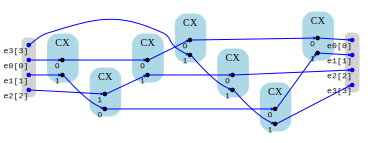

In [31]:
circ = Circuit(4).CX(0, 1).CX(1, 2).CX(0, 2).CX(0, 3).CX(2, 3).CX(1, 3).CX(0, 1)
naive_map = {
    circ.qubits[0]: node_0,
    circ.qubits[1]: node_1,
    circ.qubits[2]: node_2,
    circ.qubits[3]: node_3,
}
place_with_map(circ, naive_map)
Graph(circ).get_DAG()

So what happens when we run the following?

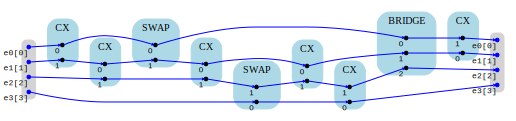

In [32]:
mapping_manager.route_circuit(circ, [lexi_route])
Graph(circ).get_DAG()

Sequential mapping typically works by partitioning the circuit into two, a first partition comprising a connected subcircuit that is physically permitted, a second partition that is not. Therefore, the first thing `MappingManager.route_circuit` does is find this partition for the passed circuit, by iterating through gates in the circuit.

We will construct the partitions ourselves for illustrative purposes. Lets assume we are routing for the four qubit line architecture (qubits are connected to adjacent indices) "simple_architecture" we constructed earlier.

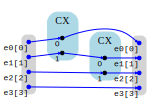

In [33]:
circ_first_partition = Circuit(4).CX(0, 1).CX(1, 2)
place_with_map(circ_first_partition, naive_map)
Graph(circ_first_partition).get_DAG()

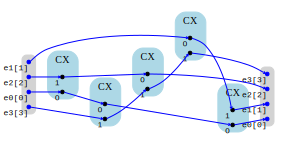

In [34]:
circ_second_partition = Circuit(4).CX(0, 2).CX(0, 3).CX(2, 3).CX(1, 3).CX(0, 1)
place_with_map(circ_second_partition, naive_map)
Graph(circ_second_partition).get_DAG()

Note that there are gates in the second partition that would be physically permitted, if they were not dependent on other gates that are not.

The next step is to modify the second partition circuit to move it closer being physically permitted. Here the `LexiRouteRoutingMethod` as before will either insert a SWAP gate at the start of the partition, or will substitute a CX gate in the first slice of the partition with a BRIDGE gate.

The option taken by `LexiRouteRoutingethod(1)` is to insert a SWAP gate between the first two nodes of the architecture, swapping their logical states. How does this change the second partition circuit?

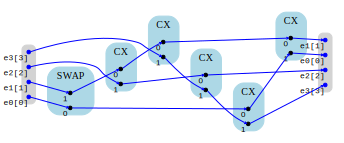

In [35]:
circ_second_partition = (
    Circuit(4).SWAP(0, 1).CX(1, 2).CX(1, 3).CX(2, 3).CX(0, 3).CX(1, 0)
)
place_with_map(circ_second_partition, naive_map)
Graph(circ_second_partition).get_DAG()

Leaving the full circuit as:

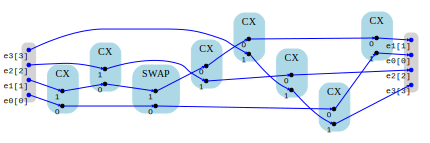

In [36]:
full_circuit = (
    Circuit(4).CX(0, 1).CX(1, 2).SWAP(0, 1).CX(1, 2).CX(1, 3).CX(2, 3).CX(0, 3).CX(1, 0)
)
place_with_map(full_circuit, naive_map)
Graph(full_circuit).get_DAG()

After a modification is made the partition is updated.

The first partition:

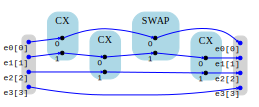

In [37]:
circ_first_partition = Circuit(4).CX(0, 1).CX(1, 2).SWAP(0, 1).CX(1, 2)
place_with_map(circ_first_partition, naive_map)
Graph(circ_first_partition).get_DAG()

The second partition:

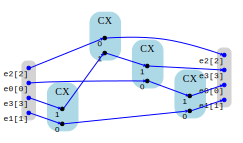

In [38]:
circ_second_partition = Circuit(4).CX(1, 3).CX(2, 3).CX(0, 3).CX(1, 0)
place_with_map(circ_second_partition, naive_map)
Graph(circ_second_partition).get_DAG()

This pattern of modification and upating the partition is repeated until the partition has reached the end of the circuit, i.e.  the back side of the partition has no gates in it. Also note that the process of updating the partition has been simplified for this example with "physically permitted" encapsulating two-qubit gate constraints only - in the future we expect other arity gates to provide constraints that need to be met. Also note that any modification to the second circuit can willfully modify the qubit labelling and a token swapping network will be automatically added to conform to the new labelling.

We now enough about how `MappingManager` works to add our own `RoutingMethodCircuit`. While `LexiRouteRoutingMethod` is implemented in c++ TKET, giving it some advantages, via lambda functions we can define our own `RoutingMethodCircuit` in python.

A python defined `RoutingMethodCircuit` requires three arguments. The first is a function that given a Circuit (the circuit after the partition) and an Architecture, returns a bool (determining whether the new circuit should be substitued in a full routing process), a new Circuit (a modification of the original circuit such as an added SWAP) a Dict between qubits reflecting any relabelling done in the method, and a Dict between qubits giving any implicit permutation of qubits (such as by adding a SWAP). For some clarity (we will write an example later), lets look at an example function declaration.

In [39]:
from typing import Dict

In [40]:
def route_subcircuit_func(
    circuit: Circuit, architecture: Architecture
) -> Tuple[bool, Circuit, Dict[Node, Node], Dict[Node, Node]]:
    return ()

The first return is a bool which detemrines if a given `RoutingMethodCircuit` is suitable for providing a solution at a given partition. `MappingManager.route_circuit` accepts a List of of `RoutingMethod` defining how solutions are found. At the point the partition circuit is modified, the circuit is passed to `RoutingMethodCircuit.routing_method` which additionally to finding a subcircuit substitution, should determine whether it can or can't helpfully modify the partition boundary circuit, and return True if it can. The first `RoutingMethodCircuit` to return True is then used for modification - meaning the ordering of List elements is important.

The third argument sets the maximum number of gates given in the passed Circuit and the fourth argument sets the maximum depth in the passed Circuit.

`LexiRouteRoutingMethod` will always return True, because it can always find some helpful SWAP to insert, and it can dynamically assign logical to physical qubits. Given this, lets construct a more specialised modification - an architecture-aware decomposition of a distance-2 CRy gate. Lets write our function type declarations for each method:

In [41]:
def distance2_CRy_decomp(
    circuit: Circuit, architecture: Architecture
) -> Tuple[bool, Circuit, Dict[Node, Node], Dict[Node, Node]]:
    return (False, Circuit(), {}, {})

Where do we start? Lets define a simple scope for our solution: for a single gate in the passed circuit (the circuit after the partition) that has OpType CRy, if the two qubits it's acting on are at distance 2 on the architecture, decompose the gate using BRIDGE gates.

The first restriction is to only have a single gate from the first slice - we can achieve this by setting both the maximum depth and size parameters to 1.

The second restriction is for the gate to have OpType CRy and for the qubits to be at distance 2 - we can check this restriction in a `distance2_CRy_check` method.

In [42]:
def distance2_CRy_check(circuit: Circuit, architecture: Architecture) -> bool:
    if circuit.n_gates != 1:
        raise ValueError(
            "Circuit for CRy check should only have 1 gate, please change parameters of method declaration."
        )
    command = circuit.get_commands()[0]
    if command.op.type == OpType.CRy:
        # Architecture stores qubits under `Node` identifier
        n0 = Node(command.qubits[0].reg_name, command.qubits[0].index)
        n1 = Node(command.qubits[1].reg_name, command.qubits[1].index)
        # qubits could not be placed in circuit, so check before finding distance
        if n0 in architecture.nodes and n1 in architecture.nodes:
            # means we can run the decomposition
            if architecture.get_distance(n0, n1) == 2:
                return True
    return False

The `distance2_CRy_check` confirms whether the required restrictions are respected. Given this, if the `distance2_CRy_decomp` method is called we know where to add the decomposition.

In [43]:
def distance2_CRy_decomp(
    circuit: Circuit, architecture: Architecture
) -> Tuple[bool, Circuit, Dict[Node, Node], Dict[Node, Node]]:
    worthwhile_substitution = distance2_CRy_check(circuit, architecture)
    if worthwhile_substitution == False:
        return (False, Circuit(), {}, {})
    command = circuit.get_commands()[0]
    qubits = command.qubits
    # Architecture stores qubits under `Node` identifier
    n0 = Node(qubits[0].reg_name, qubits[0].index)
    n1 = Node(qubits[1].reg_name, qubits[1].index)

    # need to find connecting node for decomposition
    adjacent_nodes_0 = architecture.get_adjacent_nodes(n0)
    adjacent_nodes_1 = architecture.get_adjacent_nodes(n1)
    connecting_nodes = adjacent_nodes_0.intersection(adjacent_nodes_1)
    if len(connecting_nodes) == 0:
        raise ValueError("Qubits for distance-2 CRy decomp are not at distance 2.")
    connecting_node = connecting_nodes.pop()
    c = Circuit()

    # the "relabelling map" empty, and the permutation map is qubit to qubit, so add here
    permutation_map = dict()
    for q in circuit.qubits:
        permutation_map[q] = q
        c.add_qubit(q)
    # rotation, can assume only parameter as CRy
    angle = command.op.params[0]
    c.Ry(angle, qubits[1])
    # distance-2 CX decomp
    c.CX(qubits[0], connecting_node).CX(connecting_node, qubits[1])
    c.CX(qubits[0], connecting_node).CX(connecting_node, qubits[1])
    # rotation
    c.Ry(-1 * angle, qubits[1])
    # distance-2 CX decomp
    c.CX(qubits[0], connecting_node).CX(connecting_node, qubits[1])
    c.CX(qubits[0], connecting_node).CX(connecting_node, qubits[1])

    # the "relabelling map" is just qubit to qubit
    return (True, c, {}, permutation_map)

Before turning this into a `RoutingMethod` we can try it ourselves.

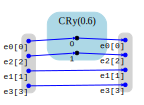

In [44]:
test_c = Circuit(4)
test_c.CRy(0.6, 0, 2)
place_with_map(test_c, naive_map)
Graph(test_c).get_DAG()

As we can see, our circuit has one CRy gate at distance two away.

In [45]:
print(distance2_CRy_check(test_c, id_architecture))

True


Our method returns True, as expected! We should also test cases where it returns errors or False.

In [46]:
test_c_false = Circuit(4)
test_c_false.CRy(0.4, 0, 1)
place_with_map(test_c_false, naive_map)
print(distance2_CRy_check(test_c_false, id_architecture))

False


In [47]:
test_c_error = Circuit(4)
test_c_error.CRy(0.6, 0, 2)
test_c_error.CRy(0.4, 0, 1)
place_with_map(test_c_error, naive_map)
try:
    distance2_CRy_check(test_c_error, id_architecture)
except ValueError:
    print("Error reached!")

Error reached!


Does the decomposition work?

In [48]:
test_c = Circuit(4)
test_c.CRy(0.6, 0, 2)
place_with_map(test_c, naive_map)
decomp = distance2_CRy_decomp(test_c, id_architecture)
display.render_circuit_jupyter(decomp[1])

Great! Our check function and decomposition method are both working. Lets wrap them into a `RoutingMethodCircuit` and try them out.

In [49]:
from pytket.mapping import RoutingMethodCircuit

In [50]:
cry_rmc = RoutingMethodCircuit(distance2_CRy_decomp, 1, 1)

We can use our original `MappingManager` object as it is defined for the same architecture. Lets try it out on a range of circumstances.

If we pass it a full CX circuit without `LexiRouteRoutingMethod`, we should find that `MappingManager` throws an error, as none of the passed methods can route for the given circuit.

In [51]:
c = (
    Circuit(4)
    .CX(0, 1)
    .CX(1, 2)
    .CX(0, 2)
    .CX(0, 3)
    .CX(2, 3)
    .CX(1, 3)
    .CX(0, 1)
    .measure_all()
)
place_with_map(c, naive_map)
try:
    mapping_manager.route_circuit(c, [cry_rmc])
except RuntimeError:
    print("Error reached!")

Error reached!


Alternatively, we can add `LexiRouteRoutingMethod` on top:

In [52]:
c = (
    Circuit(4)
    .CX(0, 1)
    .CX(1, 2)
    .CX(0, 2)
    .CX(0, 3)
    .CX(2, 3)
    .CX(1, 3)
    .CX(0, 1)
    .measure_all()
)
place_with_map(c, naive_map)
mapping_manager.route_circuit(c, [cry_rmc, LexiRouteRoutingMethod(10)])
display.render_circuit_jupyter(c)

However as there are no CRy gates our new method is unused. We can add one:

In [53]:
c = (
    Circuit(4)
    .CRy(0.6, 0, 2)
    .CX(0, 1)
    .CX(1, 2)
    .CX(0, 2)
    .CX(0, 3)
    .CX(2, 3)
    .CX(1, 3)
    .CX(0, 1)
    .measure_all()
)
mapping_manager.route_circuit(c, [lexi_label, cry_rmc, LexiRouteRoutingMethod(10)])
display.render_circuit_jupyter(c)

This time we can see our decomposition! If we reorder the methods though `LexiRouteRoutingMethod` is checked first (and returns True), so our new method is unused. The order is important!

Finally, lets see what happens if the gate is not at the right distance initially.

In [54]:
c = (
    Circuit(4)
    .CRy(0.6, 0, 3)
    .CX(0, 1)
    .CX(1, 2)
    .CX(0, 2)
    .CX(0, 3)
    .CX(2, 3)
    .CX(1, 3)
    .CX(0, 1)
    .measure_all()
)
mapping_manager.route_circuit(c, [lexi_label, cry_rmc, LexiRouteRoutingMethod(10)])
display.render_circuit_jupyter(c)

Above a SWAP gate is inserted by `LexiRouteRoutingMethod` before anything else.

For anyone interested, a simple extension exercise could be to extend this to additionally work for distance-2 CRx and CRz. Alternatively one could improve on the method itself - this approach always decomposes a CRy at distance-2, but is this a good idea?

Also note that higher performance solutions are coded straight into the TKET c++ codebase. This provides advantages, including that Circuit construction and substitution is unncessary (as with python) as the circuit can be directly modified, however the ability to produce prototypes at the python level is very helpful. If you have a great python implementation but are finding some runtime bottlenecks, why not try implementing it straight into TKET (the code is open source at https://github.com/CQCL/tket).

Besides the `LexiRouteRoutingMethod()` and the `LexiLabellingMethod()` there are other routing methods in pytket, such as the `AASRouteRoutingMethod()` and the corresponding `AASLabellingMethod()`, which are used to route phase-polynomial boxes using architecture-aware synthesis. Usually circuits contain non-phase-polynomial operations as well, so it is a good idea to combine them with the `LexiRouteRoutingMethod()`, as in the following example:

In [55]:
from pytket.mapping import AASRouteRoutingMethod, AASLabellingMethod
from pytket.circuit import PhasePolyBox, Qubit
import numpy as np

In [56]:
c = Circuit(3, 3)
n_qb = 3
qubit_indices = {Qubit(0): 0, Qubit(1): 1, Qubit(2): 2}
phase_polynomial = {(True, False, True): 0.333, (False, False, True): 0.05}
linear_transformation = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
p_box = PhasePolyBox(n_qb, qubit_indices, phase_polynomial, linear_transformation)
c.add_phasepolybox(p_box, [0, 1, 2])
c.CX(0, 1).CX(0, 2).CX(1, 2)
display.render_circuit_jupyter(c)
nodes = [Node("test", 0), Node("test", 1), Node("test", 2)]
arch = Architecture([[nodes[0], nodes[1]], [nodes[1], nodes[2]]])
mm = MappingManager(arch)
mm.route_circuit(
    c,
    [
        AASRouteRoutingMethod(1),
        LexiLabellingMethod(),
        LexiRouteRoutingMethod(),
        AASLabellingMethod(),
    ],
)
display.render_circuit_jupyter(c)

In this case the order of the methods is not very relevant, because in each step of the routing only one of the methods is suitable. In the first part of the circuit the mapping is done without inserting swaps by the AAS method; in the second part one swap gate is added to the circuit.